In [ ]:
# connect Google Drive
from google.colab import drive
from pathlib import Path
import os
drive.mount('/content/drive')

# root_path = Path('/content/drive/MyDrive/Download_scripts')
# os.chdir(root_path) 

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Download_scripts

/content/drive/MyDrive/Download_scripts


In [ ]:
# Imports
!pip install -r requirements.txt
from typing import Dict, Union, List
import folium
import pandas as pd
import numpy as np
import nltk
import re
import math
import numpy as np
import pandas as pd
from pprint import pprint
from bs4 import BeautifulSoup
import spacy
import random
import secrets
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import warnings
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE 
!pip install umap
import umap
!pip install pca
from pca import pca
stop_words = nltk.download("stopwords")
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from collections import defaultdict
import seaborn as sns
!pip install sinkhorn_knopp
from sinkhorn_knopp import sinkhorn_knopp as skp
nltk.download('punkt')

%matplotlib inline
random.seed(42)
warnings.filterwarnings("ignore",category=DeprecationWarning)
stop_words = stopwords.words('english')
stop_words.extend(['rt','http','https'])
nlp = spacy.load("en_core_web_sm")

# Data Download Script

In [ ]:
# Data Download. Uncomment this line to download more data | frequency : weekly
# !python3 run.py

# Initialising Variables and Utility Functions

In [ ]:
# Locations of analysis

tweeted_from = [
    'New Delhi',
    'Hyderabad',
    'Kolkata',
    'Lucknow',
    'Bangalore',
    'Mumbai Suburban',
    'Chandigarh',
    'Nagpur',
    'Bhopal',
    'Jaipur',
    'Chennai',
    'Gandhinagar',
    'Gurgaon',
    'Tiruchirappalli',
    'Visakhapatnam',
    'Cuttack',
    'Warangal',
    'Pune',
    # 'Bangalore Rural'
]

search_term = [
    'Rajasthan',
    'Odisha',
    'Tripura',
    'Meghalaya',
    'Chhattisgarh',
    'Tamil Nadu',
    'Jharkhand',
    'Uttar Pradesh',
    'Madhya Pradesh',
    'Gujarat',
    'Kerala',
    'Maharashtra',
    'Jammu & Kashmir',
    'Punjab',
    'Haryana',
    'West Bengal',
    'Bihar',
    'Assam',
]

In [ ]:
# Load Data

tweets1 = pd.read_csv('tweetsorg.csv', error_bad_lines = False , warn_bad_lines=False, delimiter = ',')
tweets2 = pd.read_csv('tweets2.csv', error_bad_lines = False , warn_bad_lines=False, delimiter = ',')
tweetUsers = pd.read_csv('tweetUsers.csv', error_bad_lines = False ,warn_bad_lines=False, delimiter = ',')

In [ ]:
tweets2.columns = ['retweetCount','currentPoint','userID','currentQueryLocation','_id','user','text','name']
tweets1 = tweets1[['retweetCount','currentPoint','userID','currentQueryLocation','_id','user','text','name']]

In [ ]:
tweets1 = tweets1[tweets1.currentPoint.isin(tweeted_from) & tweets1.currentQueryLocation.isin(search_term)]
tweets2 = tweets2[tweets2.currentPoint.isin(tweeted_from) & tweets2.currentQueryLocation.isin(search_term)]
print(len(tweets1), len(tweets2))

78191 54658


In [ ]:
frames = [tweets1,tweets2]
tweets = pd.concat(frames)

In [ ]:
tweets['currentPoint'].value_counts()

In [ ]:
location_of_tweetedFrom = {}

for location in tweeted_from:
  row = tweetUsers[tweetUsers.tweetedFrom == location]
  location_coordinates = (row.tweetedFromLong.mean(), row.tweetedFromLat.mean())
  location_of_tweetedFrom[location] = location_coordinates

location_of_searchTerm = {}

with open('./map.kml') as f:
  soup = BeautifulSoup(f, 'lxml-xml')
  for query in search_term:
    location_of_searchTerm[query] = []
    coords_list = soup.find_all(text=query)
    isDistrict = True
    if(len(coords_list) > 1):
      isDistrict = False
    if(isDistrict):
      coords_list = coords_list[0].parent.parent.parent.parent
      coordinates = coords_list.Polygon.outerBoundaryIs.LinearRing.coordinates.contents[0].split(' ')
      latitudes = []
      longitudes = []
      for idx, coordinate in enumerate(coordinates):
          coordinate = coordinate.split(',')
          coordinates[idx] = (float(coordinate[1]), float(coordinate[0]))
          longitudes.append(float(coordinate[0]))
          latitudes.append(float(coordinate[1]))
      latitudes = np.array(latitudes)
      longitudes = np.array(longitudes)
      location_of_searchTerm[query].append(longitudes)
      location_of_searchTerm[query].append(latitudes)
    else:
      latitudes = np.array([])
      longitudes = np.array([])
      for district in coords_list:
        district = district.parent.parent.parent.parent
        coordinates = district.Polygon.outerBoundaryIs.LinearRing.coordinates.contents[0].split(' ')
        lats = []
        longs = []
        for idx, coordinate in enumerate(coordinates):
            coordinate = coordinate.split(',')
            coordinates[idx] = (float(coordinate[1]), float(coordinate[0]))
            longs.append(float(coordinate[0]))
            lats.append(float(coordinate[1]))
        latitudes = np.append(latitudes,np.array(lats))
        longitudes = np.append(longitudes,np.array(longs))
      location_of_searchTerm[query].append(longitudes)
      location_of_searchTerm[query].append(latitudes)

for sT in location_of_searchTerm:
  location_of_searchTerm[sT] = (location_of_searchTerm[sT][0].mean(), location_of_searchTerm[sT][1].mean())

In [ ]:
# Utility Functions

def getTopicVector(topics, dictionary, num_of_topics=5):
  vector = [0] * len(dictionary)
  if(topics):
    for topic in topics:
      for word in topics[topic]:
        vector[dictionary.token2id[word[0]]]+=word[1]
  return vector

def convertToICAComponents(col,size_of_dictionary,number_of_components):
  q_vectors = pd.DataFrame.from_records(col.values,columns=[x for x in range(size_of_dictionary)],index=col.index)
  ica = FastICA(n_components=number_of_components)
  principal_components = ica.fit_transform(q_vectors)
  principalDf = pd.DataFrame(data = principal_components
             , index=topics.index, columns = ['component{}'.format(x) for x in range(number_of_components)])
  return pd.Series([[x] for x in principal_components], index=principalDf.index)

def convertToUMapComponents(col,size_of_dictionary,number_of_components):
  q_vectors = pd.DataFrame.from_records(col.values,columns=[x for x in range(size_of_dictionary)],index=col.index)
  UMap = umap.UMAP(n_components=number_of_components)
  principal_components = UMap.fit_transform(q_vectors)
  principalDf = pd.DataFrame(data = principal_components
             , index=topics.index, columns = ['component{}'.format(x) for x in range(number_of_components)])
  return pd.Series([[x] for x in principal_components], index=principalDf.index)

def convertToPCAComponents(col,size_of_dictionary,number_of_components):
  q_vectors = pd.DataFrame.from_records(col.values,columns=[x for x in range(size_of_dictionary)],index=col.index)
  pca = PCA(n_components=number_of_components)
  principal_components = pca.fit_transform(q_vectors)
  principalDf = pd.DataFrame(data = principal_components
             , index=topics.index, columns = ['component{}'.format(x) for x in range(number_of_components)])
  return pd.Series([[x] for x in principal_components], index=principalDf.index)

def convertTotSNEComponents(col,size_of_dictionary,number_of_components):
  q_vectors = pd.DataFrame.from_records(col.values,columns=[x for x in range(size_of_dictionary)],index=col.index)
  tsne = TSNE(n_components=number_of_components)
  principal_components = tsne.fit_transform(q_vectors)
  principalDf = pd.DataFrame(data = principal_components
             , index=topics.index, columns = ['component{}'.format(x) for x in range(number_of_components)])
  return pd.Series([[x] for x in principal_components], index=principalDf.index)

def remove_stopwords(text):
    return [word for word in simple_preprocess(str(text)) if word not in stop_words]

def convertStrToObject(x):
  if(isinstance(x,str)):
    return eval(x)
  return None

def sent_to_words(sentence):
    return gensim.utils.simple_preprocess(str(sentence), deacc=True)

def make_bigrams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in texts]

def lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    doc = nlp(" ".join(text)) 
    return [token.lemma_ for token in doc if token.pos_ in allowed_postags]

def read_doc_from_corpus(id2word,corpus):
    output = []
    for cp in corpus:
        output.append([id2word[cp[0]],cp[1]])
    return output
def get_top_words_of_topic(tweets,tf,st,id2word, num_topics=5,passes=50):
  data = tweets[(tweets.currentPoint == tf) & (tweets.currentQueryLocation == st)]
  if(len(data) > 0):
    corpus = [id2word.doc2bow(text) for text in data.text]
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                              id2word=id2word,
                                              num_topics=num_topics, 
                                              random_state=42,
                                              update_every=1,
                                              chunksize=100,
                                              passes=passes,
                                              alpha='auto',
                                              per_word_topics=True)
    top_words_per_topic = {}
    for t in range(lda_model.num_topics):
        top_words_per_topic[t] = [x for x in lda_model.show_topic(t, topn = 10)]
    return top_words_per_topic

In [ ]:
tweets = tweets[tweets.currentPoint.isin(tweeted_from) & tweets.currentQueryLocation.isin(search_term)]

In [ ]:
# Convert to code cell if needed to run again - takes lots of time = 2h19min
tweets['text'] = tweets.apply(lambda x: sent_to_words(x.text),axis=1)
tweets['text'] = tweets.apply(lambda x: remove_stopwords(x.text),axis=1)
# tweets.head(2)

In [ ]:
# Lemmatization : takes lot of time : uncomment if dataset changes
# ind  = 0
# for i, rows in tweets.iterrows():
#   rows['text'] = lemmatization(rows['text'])
#   if(ind%100 == 0):
#     print(ind)
#   ind += 1
# print(len(tweets))

In [ ]:
tweets.to_csv('processed.csv',index=False)

In [ ]:
# Read Tweets

tweets = pd.read_csv('processed.csv', error_bad_lines = False , warn_bad_lines=False, delimiter = ',',index_col='_id')
tweets = tweets[['currentPoint', 'userID',
       'currentQueryLocation', 'user', 'text', 'name']]#, 'language']]ƒ

# TF-IDF analysis

In [ ]:
tweets.head(5)

currentPoint  ...                                 name
_id                               ...                                     
1229831482354499584      Gurgaon  ...  ಕಿರಣ್ ಕುಮಾರ್ #ಕನ್ನಡ_ಕನ್ನಡಿಗ_ಕರ್ನಾಟಕ
1233347237545050113   Chandigarh  ...                      Jitender Sharma
1213951557730881537    Hyderabad  ...                           Umam Zaman
1233763210072715270      Cuttack  ...                   Kalpataru Tripathy
1213391316484157440      Kolkata  ...                        Arnab Maulick

[5 rows x 6 columns]

In [ ]:
tweets['text'] = tweets.apply(lambda x: eval(x.text),axis=1)

In [ ]:
id2word = corpora.Dictionary(tweets.text)
print(len(id2word))
corpus = [id2word.doc2bow(text) for text in tweets.text]
tweets.text

102963


_id
1229831482354499584            [bhavikakapoor, explanation, co, di, hhc]
1233347237545050113    [dalipias_, hr, interview, raghav, chandra, ia...
1213951557730881537    [seethakkamla, gujarat, model, development, re...
1233763210072715270    [kiituniversity, women, medley, sadhvi, dhuri,...
1213391316484157440    [worrying, india, lost, tigers, amp, leopards,...
                                             ...                        
1396793273377714176    [bstvlive, assam, टसट, डर, जग, रलव, सटशन, तर, ...
1396792561818210307    [bstvlive, assam, टसट, डर, जग, रलव, सटशन, तर, ...
1396792378372071426    [bstvlive, assam, टसट, डर, जग, रलव, सटशन, तर, ...
1396792247790624768    [bstvlive, assam, टसट, डर, जग, रलव, सटशन, तर, ...
1396791831019462658    [assam, टसट, डर, जग, रलव, सटशन, तर, हआ, यरल, c...
Name: text, Length: 132225, dtype: object

In [ ]:
# test
sentences = list()
for x in tweets.text:
  # if not x:
  #   continue
  cur_str = ""
  for y in x:
    if cur_str:
      cur_str = cur_str + ' '
    cur_str = cur_str + y
  sentences.append(cur_str)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np
import pandas as pd
import re

cvec = CountVectorizer(stop_words='english', min_df=3, max_df=0.5, ngram_range=(1,2))
sf = cvec.fit_transform(sentences)
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(sf)
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
print(weights_df.sort_values(by='weight', ascending=False).head(20))
word_list = list()
for i in range(0, 20):
  word_list.append(weights_df.sort_values(by='weight', ascending=False).iloc[i].term)

              term    weight
3322           amp  0.007570
44762       kerala  0.007247
69826    rajasthan  0.006873
32888      gujarat  0.006548
38837        india  0.006393
50763  maharashtra  0.006281
66101      pradesh  0.006086
6099         assam  0.006002
9033        bengal  0.005746
10819          bjp  0.005670
10199        bihar  0.005520
68230       punjab  0.005515
18862        covid  0.005297
42044    jharkhand  0.005115
84752        tamil  0.004993
93869         west  0.004741
56617         nadu  0.004716
84768   tamil nadu  0.004712
60326       odisha  0.004557
16140           cm  0.004454


In [ ]:
word_no_list = list()
for w in word_list:
  for x in id2word:
    if id2word[x] == w:
      word_no_list.append(x)
      print(x)
print(len(word_no_list))
id2word[571]

45
177
420
22
46
60
17
160
86
647
87
63
14609
972
64
98
61
222
304
19


'completes'

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer 
import operator
 

vocabulary = set()
for doc in sentences:
    vocabulary.update(doc.split())
 
vocabulary = list(vocabulary)
word_index = {w: idx for idx, w in enumerate(vocabulary)}
 
tfidf = TfidfVectorizer(vocabulary=vocabulary)
 
# Fit the TfIdf model
tfidf.fit(sentences)
tfidf.transform(sentences)
 
# for doc in sentences:
#     score={}
#     # print(doc)
#     # Transform a document into TfIdf coordinates
#     X = tfidf.transform([doc])
#     for word in doc.split():
#         score[word] = X[0, tfidf.vocabulary_[word]]
#     sortedscore = sorted(score.items(), key=operator.itemgetter(1), reverse=True)
#     # print("\t", sortedscore)


<132225x102963 sparse matrix of type '<class 'numpy.float64'>'
	with 1660890 stored elements in Compressed Sparse Row format>

In [ ]:
temp1 = set(tfidf.vocabulary_.keys())
temp2 = set(id2word.values())
l1 = []
l2 = []
for x in temp1:
    l1.append(x)
for x in temp2:
    l2.append(x)
l1.sort()
print(l1)
l2.sort()
print(l2)

l1 == l2
# for y in l2:
#     if y not in l1:
#         print(y)
        

['a_', 'a_blue_birdie', 'a_glasgow_smile', 'a_manushya', 'a_muqeet', 'a_sanjivshah', 'aa', 'aa_addict', 'aaaa', 'aaaaaaatttttttt', 'aaaaah', 'aaaak', 'aaabshar', 'aaachatterjee', 'aaatt', 'aaawutc', 'aab', 'aabadi', 'aabe', 'aabhar', 'aabhari', 'aabhas', 'aabhi', 'aabhiishek_kr', 'aabhradeep', 'aabidforinc', 'aabidmagami', 'aabkeshti', 'aac', 'aacha', 'aache', 'aachendin', 'aachi', 'aacohwsyhz', 'aad', 'aada', 'aadaat', 'aadadam', 'aadagaladu', 'aadami', 'aadarniya', 'aadarsh', 'aadatiyo', 'aadeshrawal', 'aadha', 'aadhaa', 'aadhaar', 'aadhaar_care', 'aadhaartribunal', 'aadhan', 'aadhar', 'aadhi', 'aadil_bhat_', 'aadil_khan', 'aadilhasanadv', 'aadishakti_', 'aaditwe', 'aaditya', 'aadityanath', 'aadivasi', 'aadiwas', 'aadmi', 'aadrfyuezv', 'aadriess', 'aadu', 'aae', 'aaefmy', 'aaega', 'aaepezxyd', 'aaey', 'aaf', 'aafrin', 'aag', 'aagai', 'aagala', 'aagan', 'aagaz', 'aage', 'aagey', 'aagiduchi', 'aagila', 'aagleh', 'aagya', 'aagyi', 'aah', 'aahat', 'aahc', 'aahdfh', 'aahe', 'aahiya', 'aah

True

In [ ]:
tfidf_data = pd.DataFrame(index=tweeted_from, columns=search_term)

In [ ]:
cnt = pd.DataFrame(index=tweeted_from, columns=search_term)
for y in cnt.columns:
    for x in cnt.index:
        cnt[y][x] = np.zeros(len(tfidf.vocabulary_))  
        tfidf_data[y][x] = np.zeros(len(tfidf.vocabulary_))


In [ ]:
for x in id2word:
    tfidf.vocabulary_[id2word[x]] = x

In [ ]:

for index, x in tweets.iterrows():
    if not x.text:
        continue
    cur_str = ""

    for y in x.text:
        if cur_str:
            cur_str = cur_str + ' '
        cur_str = cur_str + y
    score={}
    # Transform a document into TfIdf coordinates

    doc = cur_str
    X = tfidf.transform([doc])

    for word in doc.split():
        score[word] = X[0, tfidf.vocabulary_[word]]
    dest =  x.currentPoint
    src = x.currentQueryLocation


    for word in score:
        pos = tfidf.vocabulary_[word]
        tfidf_data[src][dest][pos] = tfidf_data[src][dest][pos] + score[word]*score[word]
        cnt[src][dest][pos] = cnt[src][dest][pos] + 1

In [ ]:
for y in cnt.columns:
    for x in cnt.index:
        for i in id2word:
            if cnt[y][x][i] > 0:
                tfidf_data[y][x][i] = np.sqrt(tfidf_data[y][x][i] / len(tweets))

In [ ]:
tfidf_data

Rajasthan  ...                                              Assam
New Delhi        [0.0, 0.0020379021921764283, 0.0, 0.0, 0.0, 0....  ...  [0.0, 0.0008649249384025977, 0.0, 0.0, 0.0, 0....
Hyderabad        [0.0, 0.016305120055099948, 0.0, 0.0, 0.0, 0.0...  ...  [0.0, 0.01439108163221922, 0.0, 0.0, 0.0, 0.00...
Kolkata          [0.0, 0.016473897050958922, 0.0, 0.0, 0.0, 0.0...  ...  [0.0, 0.017220270619223793, 0.0043317840919587...
Lucknow          [0.0, 0.009640873360929957, 0.0, 0.0, 0.0, 0.0...  ...  [0.0, 0.015553282539010711, 0.0, 0.0, 0.0, 0.0...
Bangalore        [0.0, 0.013001356406272271, 0.0, 0.0, 0.0, 0.0...  ...  [0.0, 0.014018210822319214, 0.0006509749457974...
Mumbai Suburban  [0.0, 0.019194472031931864, 0.0010974048737218...  ...  [0.0, 0.01621554698474185, 0.00077909084576364...
Chandigarh       [0.0, 0.013910637484387417, 0.0, 0.0, 0.0, 0.0...  ...  [0.0, 0.010706222283385766, 0.0, 0.0, 0.0, 0.0...
Nagpur           [0.0, 0.014525131749938311, 0.0, 0.0, 0.0, 0.0...  ...  [0.0, 0.012520302662008168, 0.0, 0.0, 0.0, 0.0...
Bhopal           [0.0, 0.008936851766659867, 0.0, 0.0, 0.0, 0.0...  ...  [0.0, 0.008327245872079763, 0.0, 0.0, 0.0, 0.0...
Jaipur           [0.0, 0.016055638265327056, 0.0, 0.0, 0.0, 0.0...  ...  [0.0, 0.015760364246251386, 0.0, 0.0, 0.0, 0.0...
Chennai          [0.0, 0.012249821063955882, 0.0, 0.0, 0.0, 0.0...  ...  [0.0, 0.011909084713882148, 0.0, 0.0, 0.0, 0.0...
Gandhinagar      [0.0, 0.016595576066723943, 0.0009345677864063...  ...  [0.0, 0.012939205837925868, 0.0, 0.0, 0.0, 0.0...
Gurgaon          [0.0, 0.015351648069005965, 0.0007323147486104...  ...  [0.007374981152000651, 0.025447610447139356, 0...
Tiruchirappalli  [0.0, 0.0020713459000594133, 0.0, 0.0, 0.0, 0....  ...  [0.0, 0.007213056603437044, 0.0, 0.0, 0.0, 0.0...
Visakhapatnam    [0.0, 0.01349835835548484, 0.0, 0.0, 0.0, 0.0,...  ...  [0.0, 0.005499674686316156, 0.0006994993854323...
Cuttack          [0.0, 0.013122701462264888, 0.0016597907694554...  ...  [0.0, 0.015942274520690622, 0.0, 0.0, 0.0, 0.0...
Warangal         [0.0, 0.005690104239997768, 0.0, 0.0, 0.0, 0.0...  ...  [0.0, 0.010495734685330731, 0.0, 0.0, 0.0, 0.0...
Pune             [0.001031945603275953, 0.016572053688182566, 0...  ...  [0.0, 0.015511862369355972, 0.0, 0.0, 0.0, 0.0...

[18 rows x 18 columns]

In [ ]:
nw = tfidf_data

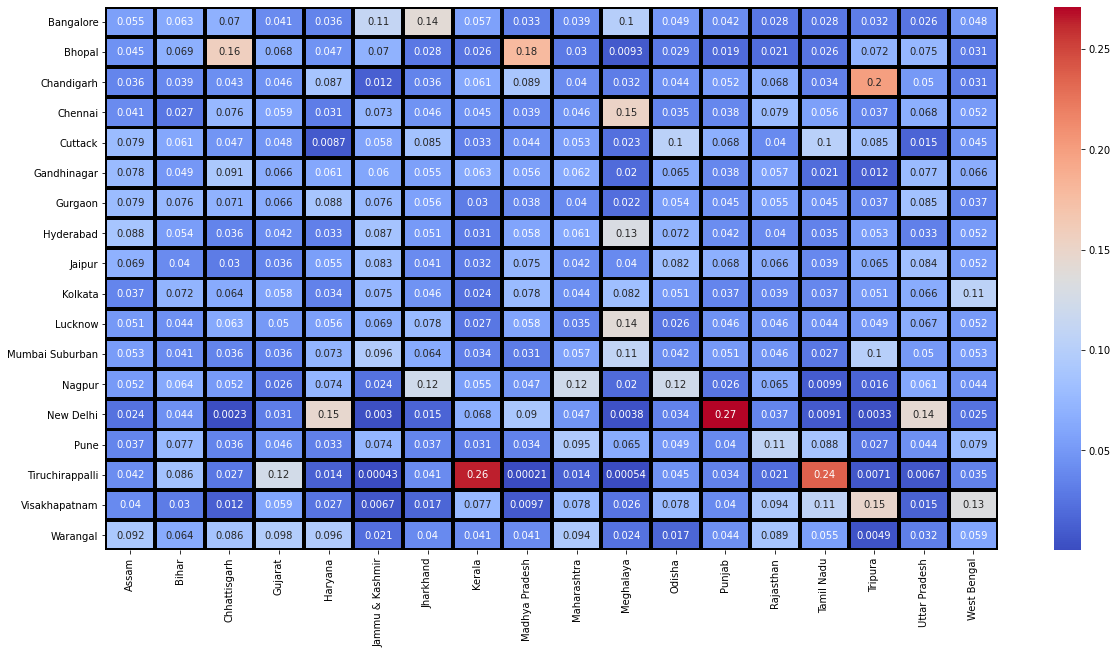

In [ ]:
nrm = []
for i, row in nw.iterrows():
  a = []
  for c2 in search_term:
    l = row[c2]
    # print(l)
    # break
    l.sort()
    l = l[::-1]
    val = 0
    for elm in l[:25]:
      val += elm**2
    a.append(val)
  # break
  nrm.append(a)

dummy, epsilon = 0, 1e-6
for ind1 in range(18):
  for ind2 in range(18):
    if nrm[ind1][ind2] == 0:
      nrm[ind1][ind2] = epsilon
      
np_nrm = np.matrix(nrm)
sk = skp.SinkhornKnopp()
sk_mat_tfidf = sk.fit(np_nrm)
C = pd.DataFrame(sk_mat_tfidf)
C.columns = ['Rajasthan',
    'Odisha',
    'Tripura',
    'Meghalaya',
    'Chhattisgarh',
    'Tamil Nadu',
    'Jharkhand',
    'Uttar Pradesh',
    'Madhya Pradesh',
    'Gujarat',
    'Kerala',
    'Maharashtra',
    'Jammu & Kashmir',
    'Punjab',
    'Haryana',
    'West Bengal',
    'Bihar',
    'Assam']
C.index = ['New Delhi','Hyderabad','Kolkata',
    'Lucknow',
    'Bangalore',
    'Mumbai Suburban',
    'Chandigarh',
    'Nagpur',
    'Bhopal',
    'Jaipur',
    'Chennai',
    'Gandhinagar',
    'Gurgaon',
    'Tiruchirappalli',
    'Visakhapatnam',
    'Cuttack',
    'Warangal',
    'Pune'
]
C.sort_index(axis=1, inplace = True)
C.sort_index(inplace=True)
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(C, annot=True, linewidths=3, linecolor='black', ax = ax, cmap='coolwarm')

# Doctag2Vec Analysis

In [ ]:
# Making Tagged Data

import math
data = []
indices = {} # dictionary of srcdest -> index
num = 0
tweet_origin, tweet_destination = [], []
for index, tweet in tweets.iterrows():
  t = ''
  for w in tweet.text:
    t += w + ' '
  data.append(t)
  tweet_origin.append(tweet.currentPoint)
  tweet_destination.append(tweet.currentQueryLocation)
  try:
    indices[tweet.currentPoint+'|'+tweet.currentQueryLocation].add(num)
  except KeyError:
    indices[tweet.currentPoint+'|'+tweet.currentQueryLocation] = {num}
  num += 1
# print(type(data), type(data[0]))
tagged_data = [TaggedDocument(words=word_tokenize(_d), tags=[str(i),tweet_origin[i],tweet_destination[i]]) for i, _d in enumerate(data)]

In [ ]:
# Training model - modify and train

max_epochs = 20
vec_size = 25
alpha = 0.025

norms = [] # 1-D vector containing vector of norms for each s-d pair
centroid_vectors = [] # 2-D vector containing vector of centroid vectors of each vector space, ind1 - s-d wise ; ind2 - one of vec_size-dims
tag_vectors = [] # 2-D vector containing vector of tag vectors for each vector space, ind1 - city wise ; ind2 - one of vec_size-dims
city_vectors = [] # Order of encounter of cities

sz = []

# Train the model
model = Doc2Vec(vector_size = vec_size, alpha = alpha, min_alpha = 0.00025, min_count = 1, dm = 1)
model.build_vocab(tagged_data)
for epoch in range(max_epochs):
  print(epoch)
  model.train(tagged_data,total_examples=model.corpus_count,epochs=model.iter)
  # Decrease the learning rate
  model.alpha -= 0.0002
  # Fix the learning rate, no decay
  model.min_alpha = model.alpha
  
cities = set()
for key in indices: # for each city pair store the norms and the centroid vector
  #  Find Centroid
  centroid = [0]*vec_size
  list_ = indices[key] # list of tweet indices for this key
  for tweet_index in list_:
    centroid = [sum(x) for x in zip(centroid, model.docvecs[tweet_index])]
  centroid = [x/len(list_) for x in centroid]
  centroid_vectors.append(centroid)
  # Find Norm
  norm = 0
  for val in centroid:
      norm += val**2
  norm = math.sqrt(norm/vec_size)
  norms.append(norm)
  # Get Tag vectors
  pair = key.split('|')
  if pair[0] not in cities:
    cities.add(pair[0])
    tag_vectors.append(model.docvecs[pair[0]])
    city_vectors.append(pair[0])
  if pair[1] not in cities:
    cities.add(pair[1])
    tag_vectors.append(model.docvecs[pair[1]])
    city_vectors.append(pair[1])
  sz.append(len(list_))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


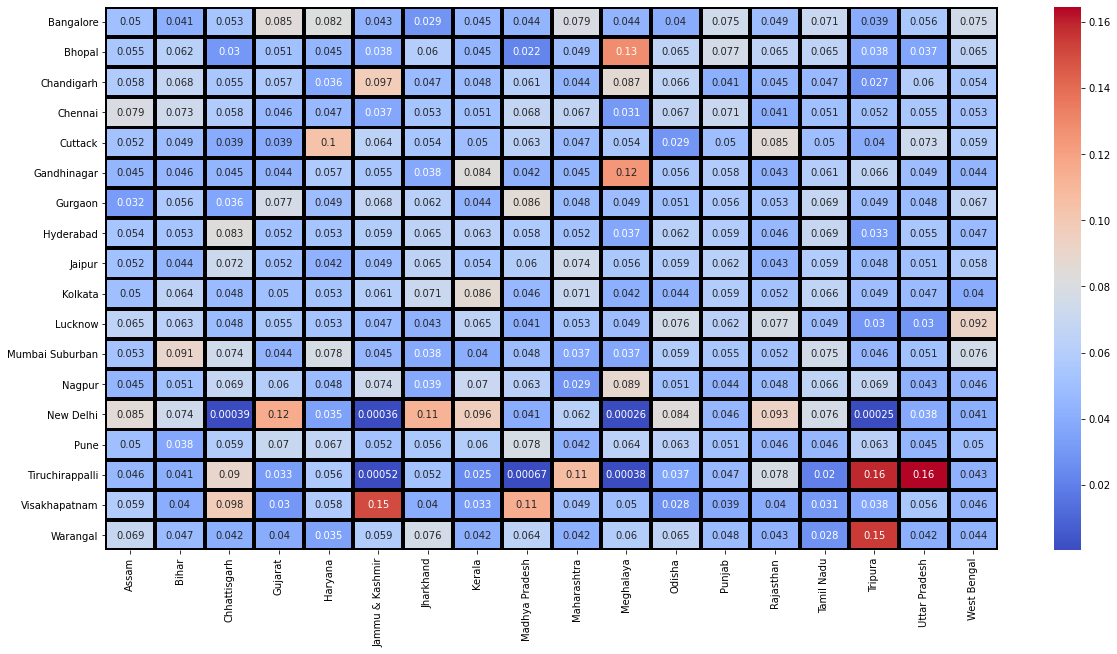

In [ ]:
# 1. Norms of s-d vector

# Constructing dictionary
dictionary1 = defaultdict(dict)
ind = 0 
for key in indices: # iterate over s-d pairs
  val = 0
  pair = key.split('|')
  for index in range(len(centroid_vectors[ind])): # iterate
    val += centroid_vectors[ind][index]*centroid_vectors[ind][index]
  dictionary1[pair[0]][pair[1]] = math.sqrt(val)#/sz[ind]
  ind += 1

# Filling empty places in dictionary
l1, l2 = [], []
for c in sorted(dictionary1):
  l1.append(c)
for c in sorted(search_term):
  l2.append(c)
dummy, epsilon = 0, 1e-2
for c1 in l1:
  for c2 in l2:
    try:
      dummy = dictionary1[c1][c2]
    except KeyError:
      dictionary1[c1][c2] = epsilon

# Sinkhorn normal decomposition and display
mat1 = [[abs(dictionary1[tier1][tier2]) for tier2 in sorted(dictionary1[tier1])] for tier1 in sorted(dictionary1)]
np_mat = np.matrix(mat1)
sk = skp.SinkhornKnopp()
sk_mat1 = sk.fit(np_mat)
df1 = pd.DataFrame(sk_mat1)
df1.columns = ['Assam', 'Bihar', 'Chhattisgarh', 'Gujarat', 'Haryana', 'Jammu & Kashmir', 'Jharkhand', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Meghalaya', 'Odisha', 'Punjab', 'Rajasthan', 'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'West Bengal']
df1.index = ['Bangalore', 'Bhopal', 'Chandigarh', 'Chennai', 'Cuttack', 'Gandhinagar', 'Gurgaon', 'Hyderabad', 'Jaipur', 'Kolkata', 'Lucknow', 'Mumbai Suburban', 'Nagpur', 'New Delhi', 'Pune', 'Tiruchirappalli', 'Visakhapatnam', 'Warangal']
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(df1, annot=True, linewidths=3, linecolor='black', ax = ax, cmap='coolwarm')

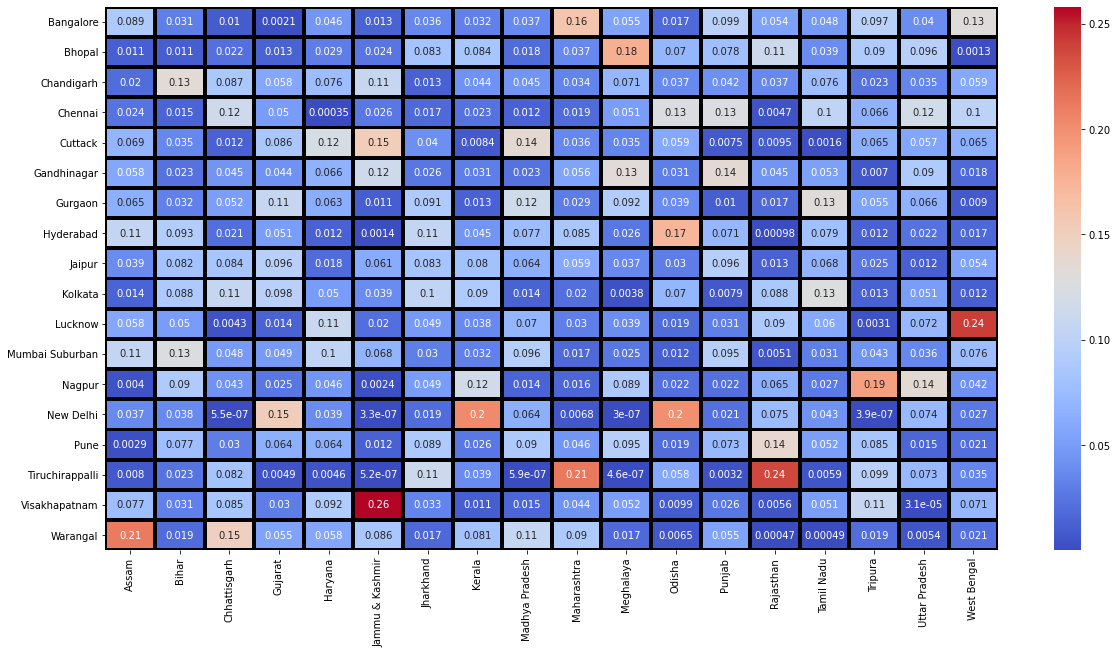

In [ ]:
# 2. Component along sum(s) - sum(d)

# Find sum(s) and sum(d) and sum(s)-sum(d)
sum_tire1, sum_tire2 = [0]*vec_size, [0]*vec_size
index = 0
for city in city_vectors:
  if city in tweeted_from:
    sum_tire1 = [x + y for x,y in zip(sum_tire1, tag_vectors[index])]
  else:
    sum_tire2 = [x + y for x,y in zip(sum_tire2, tag_vectors[index])]
  index += 1
diff = [x - y for x,y in zip(sum_tire1, sum_tire2)]

# Constructing Dictionary
dictionary2 = defaultdict(dict)
ind = 0
for key in indices: # iterate over s-d pairs
  val = 0
  pair = key.split('|')
  for index in range(len(centroid_vectors[ind])): 
    val += diff[index]*centroid_vectors[ind][index]
  dictionary2[pair[0]][pair[1]] = val#/sz[ind]
  ind += 1

# Filling empty places in dictionary
dummy, epsilon = 0, 1e-6
for c1 in l1:
  for c2 in l2:
    try:
      dummy = dictionary2[c1][c2]
    except KeyError:
      dictionary2[c1][c2] = epsilon

# Sinkhorn normal decomposition and display
mat2 = [[abs(dictionary2[tier1][tier2]) for tier2 in sorted(dictionary2[tier1])] for tier1 in sorted(dictionary2)]
np_mat = np.matrix(mat2)
sk = skp.SinkhornKnopp()
sk_mat2 = sk.fit(np_mat)
df2 = pd.DataFrame(sk_mat2)
df2.columns = ['Assam', 'Bihar', 'Chhattisgarh', 'Gujarat', 'Haryana', 'Jammu & Kashmir', 'Jharkhand', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Meghalaya', 'Odisha', 'Punjab', 'Rajasthan', 'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'West Bengal']
df2.index = ['Bangalore', 'Bhopal', 'Chandigarh', 'Chennai', 'Cuttack', 'Gandhinagar', 'Gurgaon', 'Hyderabad', 'Jaipur', 'Kolkata', 'Lucknow', 'Mumbai Suburban', 'Nagpur', 'New Delhi', 'Pune', 'Tiruchirappalli', 'Visakhapatnam', 'Warangal']
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(df2, annot=True, linewidths=3, linecolor='black', ax = ax, cmap='coolwarm')

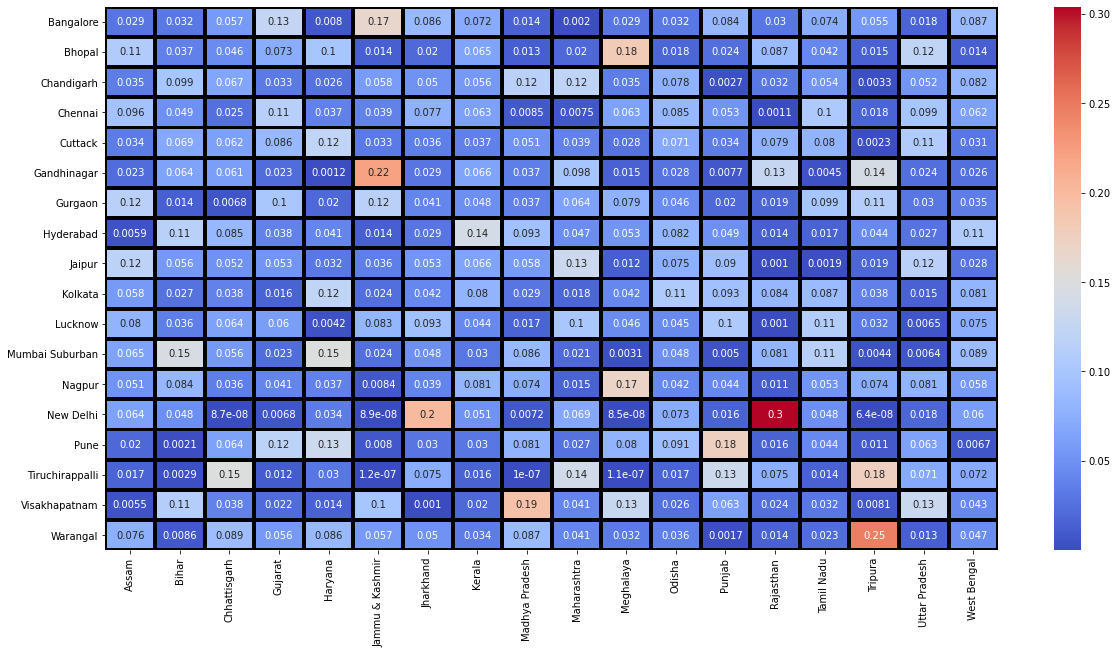

In [ ]:
# 3. Component along sum(s_unit) - sum(d_unit)

# Find sum(s) and sum(d) and sum(s)-sum(d)
sum_tire1_unit, sum_tire2_unit = [0]*vec_size, [0]*vec_size
index = 0
for city in city_vectors:
  if city in tweeted_from:
    sq_val = 0
    for values in tag_vectors[index]:
      sq_val += values*values
    v = tag_vectors[index]/math.sqrt(sq_val)
    sum_tire1_unit = [x + y for x,y in zip(sum_tire1_unit, v)]
  else:
    sum_tire2_unit = [x + y for x,y in zip(sum_tire2_unit, v)]
  index += 1
diff = [x - y for x,y in zip(sum_tire1_unit, sum_tire2_unit)]

# Constructing Dictionary
dictionary3 = defaultdict(dict)
ind = 0
for key in indices: # iterate over s-d pairs
  val = 0
  pair = key.split('|')
  for index in range(len(centroid_vectors[ind])): 
    val += diff[index]*centroid_vectors[ind][index]
  dictionary3[pair[0]][pair[1]] = val#/sz[ind]
  ind += 1

# Filling empty places in dictionary
dummy, epsilon = 0, 1e-6
for c1 in l1:
  for c2 in l2:
    try:
      dummy = dictionary3[c1][c2]
    except KeyError:
      dictionary3[c1][c2] = epsilon

# Sinkhorn normal decomposition and display
mat3 = [[abs(dictionary3[tier1][tier2]) for tier2 in sorted(dictionary3[tier1])] for tier1 in sorted(dictionary3)]
np_mat = np.matrix(mat3)
sk = skp.SinkhornKnopp()
sk_mat3 = sk.fit(np_mat)
df3 = pd.DataFrame(sk_mat3)
df3.columns = ['Assam', 'Bihar', 'Chhattisgarh', 'Gujarat', 'Haryana', 'Jammu & Kashmir', 'Jharkhand', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Meghalaya', 'Odisha', 'Punjab', 'Rajasthan', 'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'West Bengal']
df3.index = ['Bangalore', 'Bhopal', 'Chandigarh', 'Chennai', 'Cuttack', 'Gandhinagar', 'Gurgaon', 'Hyderabad', 'Jaipur', 'Kolkata', 'Lucknow', 'Mumbai Suburban', 'Nagpur', 'New Delhi', 'Pune', 'Tiruchirappalli', 'Visakhapatnam', 'Warangal']
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(df3, annot=True, linewidths=3, linecolor='black', ax = ax, cmap='coolwarm')

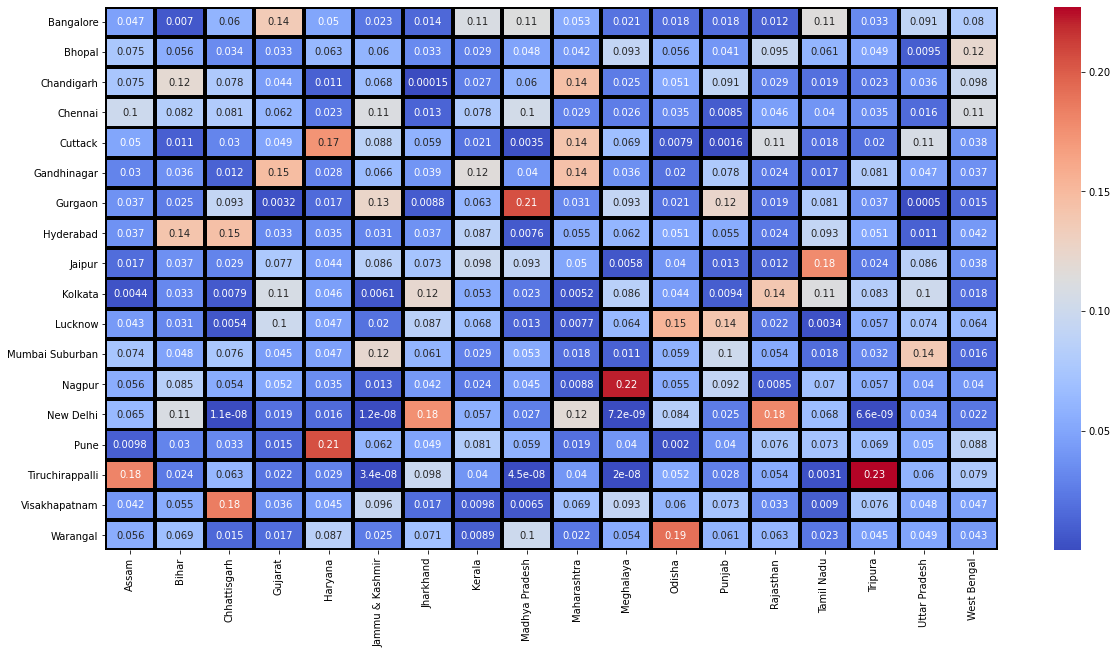

In [ ]:
# 4. Component of s-d vectors along si - dj

# Constructing Dictionary
dictionary4 = defaultdict(dict)
ind = 0
for key in indices: # iterate over s-d pairs
  val = 0
  pair = key.split('|')
  v = model.docvecs[pair[0]] - model.docvecs[pair[1]]# si - dj
  for index in range(len(centroid_vectors[ind])): 
    val += v[index]*centroid_vectors[ind][index]
  dictionary4[pair[0]][pair[1]] = val#/sz[ind]
  ind += 1

# Filling empty places in dictionary
dummy, epsilon = 0, 1e-6
for c1 in l1:
  for c2 in l2:
    try:
      dummy = dictionary4[c1][c2]
    except KeyError:
      dictionary4[c1][c2] = epsilon

# Sinkhorn normal decomposition and display
mat4 = [[abs(dictionary4[tier1][tier2]) for tier2 in sorted(dictionary4[tier1])] for tier1 in sorted(dictionary4)]
np_mat = np.matrix(mat4)
sk = skp.SinkhornKnopp()
sk_mat4 = sk.fit(np_mat)
df4 = pd.DataFrame(sk_mat4)
df4.columns = ['Assam', 'Bihar', 'Chhattisgarh', 'Gujarat', 'Haryana', 'Jammu & Kashmir', 'Jharkhand', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Meghalaya', 'Odisha', 'Punjab', 'Rajasthan', 'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'West Bengal']
df4.index = ['Bangalore', 'Bhopal', 'Chandigarh', 'Chennai', 'Cuttack', 'Gandhinagar', 'Gurgaon', 'Hyderabad', 'Jaipur', 'Kolkata', 'Lucknow', 'Mumbai Suburban', 'Nagpur', 'New Delhi', 'Pune', 'Tiruchirappalli', 'Visakhapatnam', 'Warangal']
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(df4, annot=True, linewidths=3, linecolor='black', ax = ax, cmap='coolwarm')

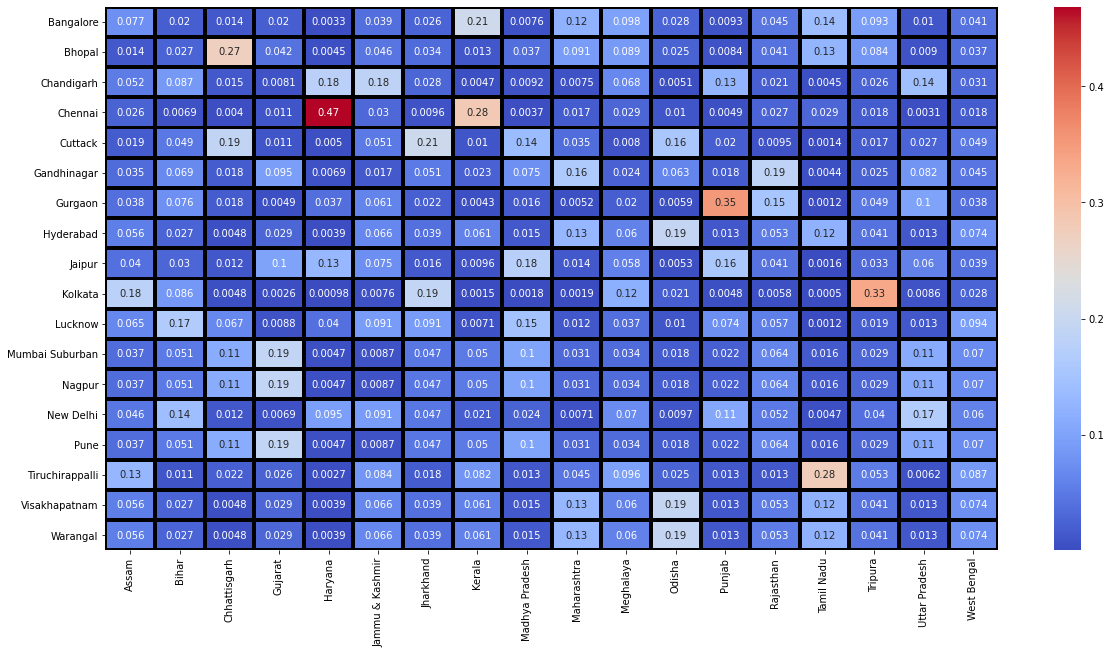

In [ ]:
# From Census Data
bang = [23651,86083,7582,38953,12511,9326,21064,334181,22610,586864,1959,64032,11819,150359,736821,1896,92495,67639]
# bang = [x/sum(bang) for x in bang]
bhopal = [4901,125836,167340,88702,19224,12100,30272,22566,21894713,494312,1959,64032,11819,150359,736821,1896,92495,67639]
# bhopal = [x/sum(bhopal) for x in bhopal]
chandigarh = [2166,50703,1123,2082,93037,5997,3023,1016,3730,4999,183,1600,148841,9446,3223,73,179574,6951]
# chandigarh = [x/sum(chandigarh) for x in chandigarh]
chennai = [7860,29277,2174,21024,5172,7221,7581,447701,10917,82197,567,22863,6082,88474,29351926,374,27985,28829]
# chennai = [x/sum(chennai) for x in chennai]
cuttack = [3888,143216,7554503,13704,12807,8321,111325,10747,276527,117487,107,242404,17217,21188,4879,237,168385,53766]
# cuttack = [x/sum(cuttack) for x in cuttack]
gandhinagar = [13030,361010,12397,22761198,32206,4883,49576,44356,274773,971975,585,176072,27549,747445,28620,627,929411,89040]
# gandhinagar = [x/sum(gandhinagar) for x in gandhinagar]
gurgaon = [14088,390937,11813,11250,6797636,17700,20853,8302,56240,30907,481,16280,538328,611160,7724,1204,1113535,75893]
# gurgaon = [x/sum(gurgaon) for x in gurgaon]
hyderabad = [7155,48120,1110,23299,6220,6583,13024,40113,18444,263216,499,185872,6861,72554,266720,349,49889,50218]
# hyderabad = [x/sum(hyderabad) for x in hyderabad]
jaipur = [12936,134402,7266,200767,533963,19100,13183,16128,554058,73366,1226,12991,213308,19240666,9042,717,585982,67695]
# jaipur = [x/sum(jaipur) for x in jaipur]
kolkata = [166400,1103757,8071,14563,11259,5486,459436,7149,15815,27468,7000,142179,18154,57668,7932,20497,238819,29052806]
# kolkata = [x/sum(kolkata) for x in kolkata]
lucknow = [30157,1072739,56676,25459,230740,33008,110358,17106,668537,88310,1125,35269,142235,284056,9458,598,52000937,234042]
# lucknow = [x/sum(lucknow) for x in lucknow]
mumbai = [30614,586667,168379,983653,48673,5607,100285,214889,824624,47924588,1842,114411,73951,570233,226029,1577,2754706,309766]
# mumbai = [x/sum(mumbai) for x in mumbai]
nagpur = [30614,586667,168379,983653,48673,5607,100285,214889,824624,47924588,1842,114411,73951,570233,226029,1577,2754706,309766]
# nagpur = [x/sum(nagpur) for x in nagpur]
delhi = [26233,1106629,12634,24153,666331,40146,69196,60297,134867,63692,2569,41162,247966,315238,45862,1490,2854297,182356]
# delhi = [x/sum(delhi) for x in delhi]
pune = [30614,586667,168379,983653,48673,5607,100285,214889,824624,47924588,1842,114411,73951,570233,226029,1577,2754706,309766]
# pune = [x/sum(pune) for x in pune]
tiruchpalli = [8469,9904,2563,10443,2228,4293,3109,17053517,8345,47464,410,12223,3402,8893,311347,232,12203,30470]
# tiruchpalli = [x/sum(tiruchpalli) for x in tiruchpalli]
vizak = [7155,48120,1110,23299,6220,6583,13024,40113,18444,263216,499,185872,6861,72554,266720,349,49889,50218]
# vizak = [x/sum(vizak) for x in vizak]
warangal = [7155,48120,1110,23299,6220,6583,13024,40113,18444,263216,499,185872,6861,72554,266720,349,49889,50218]
# warangal = [x/sum(warangal) for x in warangal]


b = [
     bang,bhopal,chandigarh,chennai,cuttack,gandhinagar,gurgaon,hyderabad,jaipur,kolkata,lucknow,mumbai,nagpur,delhi,pune,tiruchpalli,vizak,warangal
]
for ind1 in range(18):
  for ind2 in range(18):
    if (ind1==1 and ind2==8) or (ind1==2 and ind2==12) or (ind1==3 and ind2==4) or (ind1==3 and ind2==14) or (ind1==4 and ind2==2) or (ind1==5 and ind2==3) or (ind1==6 and ind2==4) or (ind1==8 and ind2==13) or (ind1==9 and ind2==17) or (ind1==10 and ind2==16) or (ind1==11 and ind2==9) or (ind1==12 and ind2==9) or (ind1==14 and ind2==9) or (ind1==15 and ind2==7):
      b[ind1][ind2] = (sum(b[ind1])-b[ind1][ind2])/17

bb = np.matrix(b)
sk = skp.SinkhornKnopp()
sk_mat_census = sk.fit(bb)
B = pd.DataFrame(sk_mat_census)
B.columns = ['Assam', 'Bihar', 'Chhattisgarh', 'Gujarat', 'Haryana', 'Jammu & Kashmir', 'Jharkhand', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Meghalaya', 'Odisha', 'Punjab', 'Rajasthan', 'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'West Bengal']
B.index = ['Bangalore', 'Bhopal', 'Chandigarh', 'Chennai', 'Cuttack', 'Gandhinagar', 'Gurgaon', 'Hyderabad', 'Jaipur', 'Kolkata', 'Lucknow', 'Mumbai Suburban', 'Nagpur', 'New Delhi', 'Pune', 'Tiruchirappalli', 'Visakhapatnam', 'Warangal']
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(B, annot=True, linewidths=3, linecolor='black', ax = ax, cmap='coolwarm')

In [ ]:
val1, val2, val3, val4, val5 = 0,0,0,0, 0
# 1
for ind1 in range(18):
  for ind2 in range(18):
    val1 += abs(sk_mat1[ind1][ind2]-sk_mat_census[ind1][ind2])**2
val1 = math.sqrt(val1)
print("1 - ",val1)
#2
for ind1 in range(18):
  for ind2 in range(18):
    val2 += abs(sk_mat2[ind1][ind2]-sk_mat_census[ind1][ind2])**2
val2 = math.sqrt(val2)
print("2 - ",val2)
#3
for ind1 in range(18):
  for ind2 in range(18):
    val3 += abs(sk_mat3[ind1][ind2]-sk_mat_census[ind1][ind2])**2
val3 = math.sqrt(val3)
print("3 - ",val3)
#4
for ind1 in range(18):
  for ind2 in range(18):
    val4 += abs(sk_mat4[ind1][ind2]-sk_mat_census[ind1][ind2])**2
val4 = math.sqrt(val4)
print("4 - ",val4)
# 5
for ind1 in range(18):
  for ind2 in range(18):
    val5 += abs(sk_mat_tfidf[ind1][ind2]-sk_mat_census[ind1][ind2])**2
val5 = math.sqrt(val5)
print("5 - ",val5)

1 -  1.236915036387513
2 -  1.4589068788225341
3 -  1.4527406301192236
4 -  1.3743222467343108
5 -  1.2714919210596711


In [ ]:
print(100 - 100*(val1/6))
print(100 - 100*(val2/6))
print(100 - 100*(val3/6))
print(100 - 100*(val4/6))
print(100 - 100*(val5/6))

79.38474939354145
75.68488535295776
75.7876561646796
77.09462922109482
78.80846798233881


In [ ]:
from scipy import stats

In [ ]:
# Row and Column Correlation with Census Data
print("Column")
ind = 1
print("\nModel - 1 : ")
for i in range(18):
  v = stats.spearmanr(sk_mat1[:][i],sk_mat_census[:][i])
  print(ind, v[0])
  ind+=1
ind = 1
print("\nModel - 2 : ")
for i in range(18):
  v = stats.spearmanr(sk_mat2[:][i],sk_mat_census[:][i])
  print(ind, v[0])
  ind+=1
ind = 1
print("\nModel - 3 : ")
for i in range(18):
  v = stats.spearmanr(sk_mat3[:][i],sk_mat_census[:][i])
  print(ind, v[0])
  ind+=1
ind = 1
print("\nModel - 4 : ")
for i in range(18):
  v = stats.spearmanr(sk_mat4[:][i],sk_mat_census[:][i])
  print(ind, v[0])
  ind+=1
ind = 1
print("\nModel - 5 : ")
for i in range(18):
  v = stats.spearmanr(sk_mat_tfidf[:][i],sk_mat_census[:][i])
  print(ind, v[0])
  ind+=1
print("\n\nRow")
ind = 1
print("\nModel - 1 : ")
for i in range(18):
  v = stats.spearmanr(sk_mat1[i],sk_mat_census[i])
  print(ind, v[0])
  ind+=1
ind = 1
print("\nModel - 2 : ")
for i in range(18):
  v = stats.spearmanr(sk_mat2[i],sk_mat_census[i])
  print(ind, v[0])
  ind+=1
ind = 1
print("\nModel - 3 : ")
for i in range(18):
  v = stats.spearmanr(sk_mat3[i],sk_mat_census[i])
  print(ind, v[0])
  ind+=1
ind = 1
print("\nModel - 4 : ")
for i in range(18):
  v = stats.spearmanr(sk_mat4[i],sk_mat_census[i])
  print(ind, v[0])
  ind+=1
ind = 1
print("\nModel - 5 : ")
for i in range(18):
  v = stats.spearmanr(sk_mat_tfidf[i],sk_mat_census[i])
  print(ind, v[0])
  ind+=1
ind = 1

Column

Model - 1 : 
1 -0.1475748194014448
2 -0.038183694530443756
3 0.17647058823529413
4 -0.6470588235294118
5 -0.23632610939112486
6 -0.6181630546955624
7 -0.05882352941176471
8 -0.03611971104231166
9 -0.32301341589267285
10 -0.3519091847265222
11 -0.038183694530443756
12 -0.08152734778121776
13 -0.08771929824561403
14 -0.3766769865841073
15 -0.027863777089783277
16 -0.4674922600619195
17 -0.3457172342621259
18 0.1393188854489164

Model - 2 : 
1 0.32094943240454077
2 -0.013415892672858616
3 0.16202270381836945
4 -0.3106295149638803
5 0.2507739938080495
6 -0.3498452012383901
7 -0.4447884416924664
8 0.23632610939112486
9 -0.08359133126934985
10 -0.3003095975232198
11 0.27347781217750256
12 0.0629514963880289
13 0.23219814241486067
14 -0.23219814241486067
15 0.08565531475748193
16 -0.17440660474716205
17 0.025799793601651185
18 -0.16408668730650156

Model - 3 : 
1 0.09803921568627451
2 -0.20743034055727552
3 -0.31475748194014447
4 -0.013415892672858616
5 -0.18059855521155832
6 0.323013

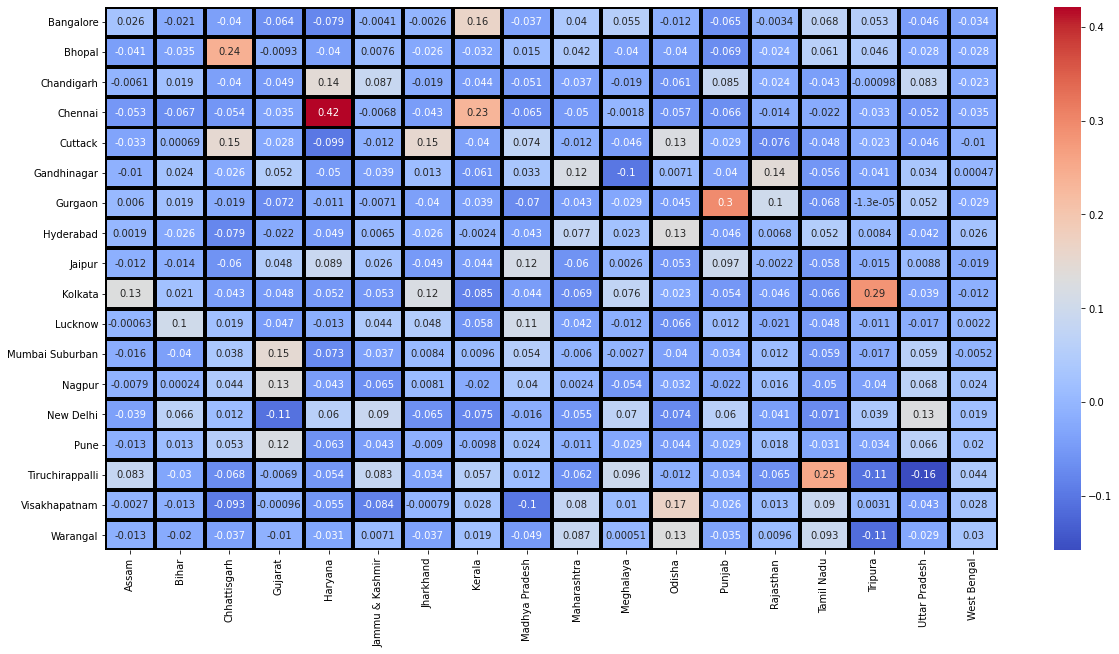

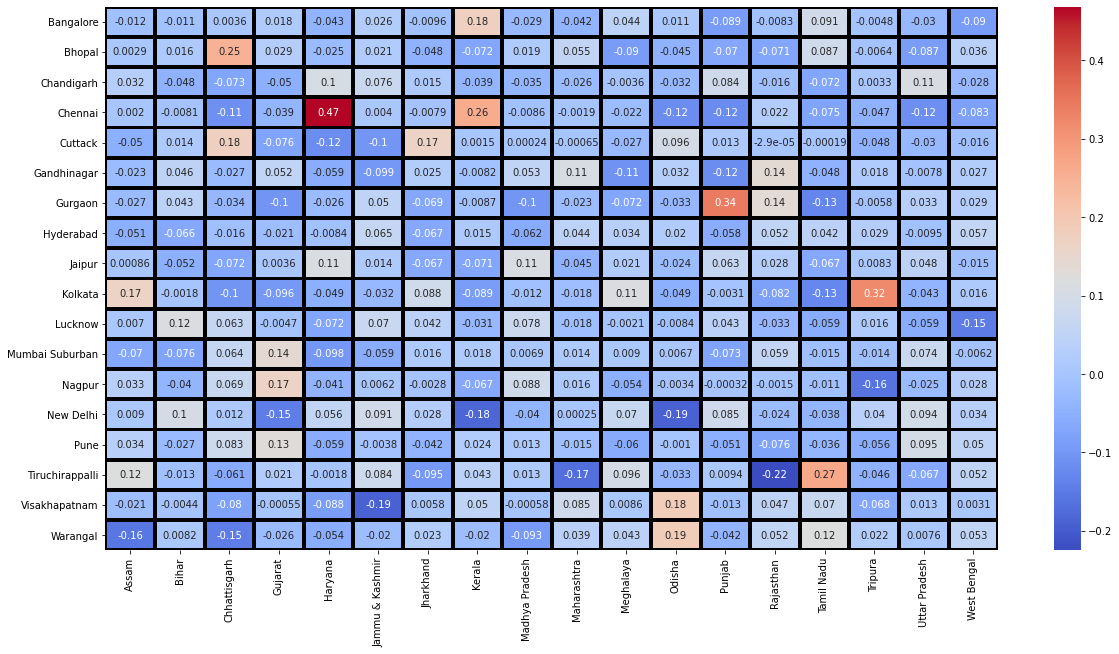

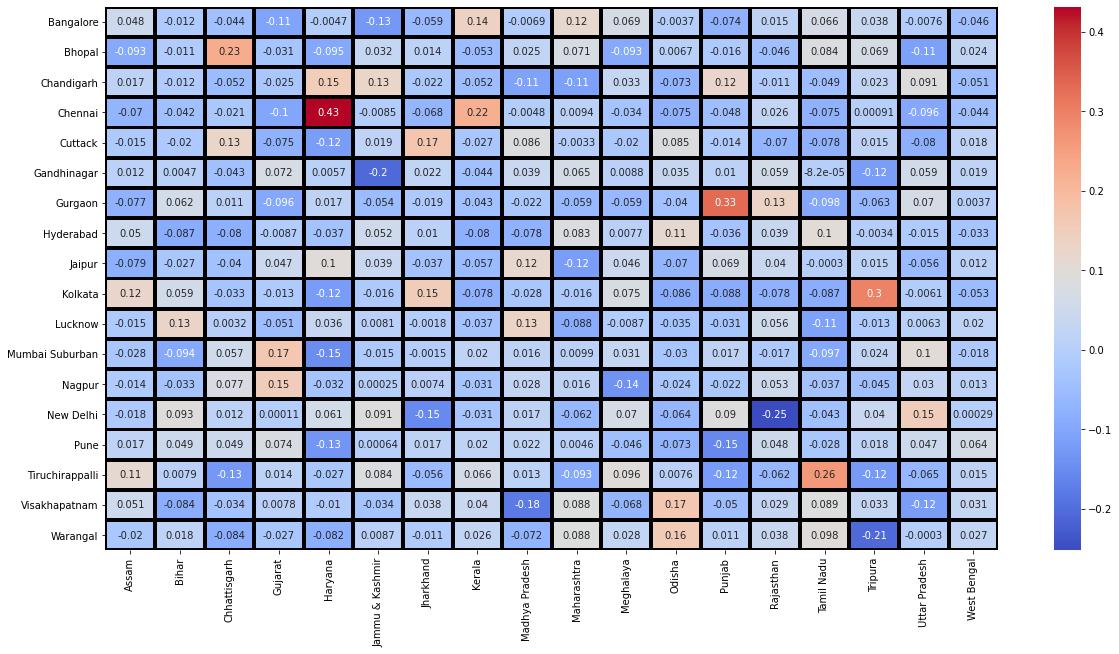

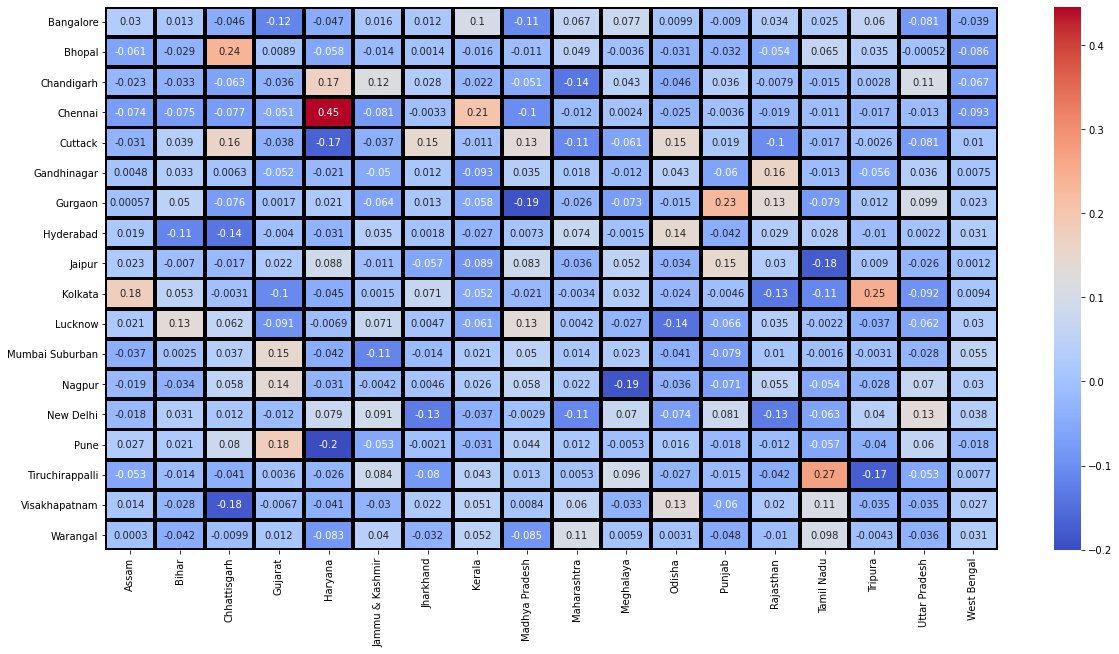

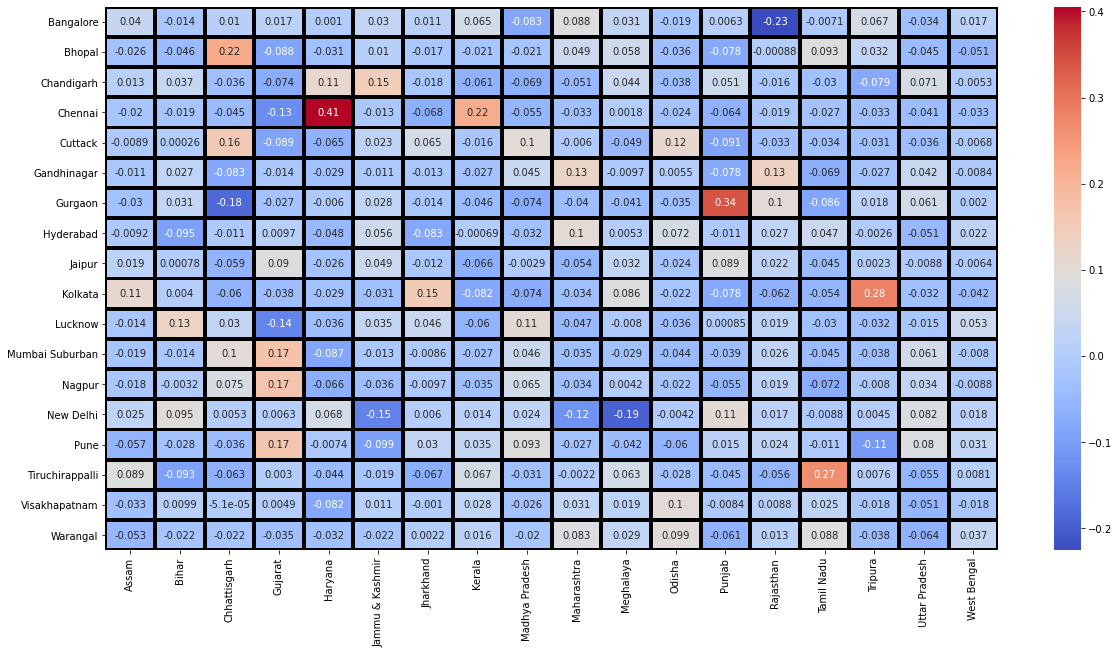

In [ ]:
# Difference between matrices and census matrix
diff1 = sk_mat_census - sk_mat1
A1 = pd.DataFrame(diff1)
A1.columns = ['Assam', 'Bihar', 'Chhattisgarh', 'Gujarat', 'Haryana', 'Jammu & Kashmir', 'Jharkhand', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Meghalaya', 'Odisha', 'Punjab', 'Rajasthan', 'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'West Bengal']
A1.index = ['Bangalore', 'Bhopal', 'Chandigarh', 'Chennai', 'Cuttack', 'Gandhinagar', 'Gurgaon', 'Hyderabad', 'Jaipur', 'Kolkata', 'Lucknow', 'Mumbai Suburban', 'Nagpur', 'New Delhi', 'Pune', 'Tiruchirappalli', 'Visakhapatnam', 'Warangal']
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(A1, annot=True, linewidths=3, linecolor='black', ax = ax, cmap='coolwarm')

diff2 = sk_mat_census - sk_mat2
A2 = pd.DataFrame(diff2)
A2.columns = ['Assam', 'Bihar', 'Chhattisgarh', 'Gujarat', 'Haryana', 'Jammu & Kashmir', 'Jharkhand', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Meghalaya', 'Odisha', 'Punjab', 'Rajasthan', 'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'West Bengal']
A2.index = ['Bangalore', 'Bhopal', 'Chandigarh', 'Chennai', 'Cuttack', 'Gandhinagar', 'Gurgaon', 'Hyderabad', 'Jaipur', 'Kolkata', 'Lucknow', 'Mumbai Suburban', 'Nagpur', 'New Delhi', 'Pune', 'Tiruchirappalli', 'Visakhapatnam', 'Warangal']
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(A2, annot=True, linewidths=3, linecolor='black', ax = ax, cmap='coolwarm')

diff3 = sk_mat_census - sk_mat3
A3 = pd.DataFrame(diff3)
A3.columns = ['Assam', 'Bihar', 'Chhattisgarh', 'Gujarat', 'Haryana', 'Jammu & Kashmir', 'Jharkhand', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Meghalaya', 'Odisha', 'Punjab', 'Rajasthan', 'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'West Bengal']
A3.index = ['Bangalore', 'Bhopal', 'Chandigarh', 'Chennai', 'Cuttack', 'Gandhinagar', 'Gurgaon', 'Hyderabad', 'Jaipur', 'Kolkata', 'Lucknow', 'Mumbai Suburban', 'Nagpur', 'New Delhi', 'Pune', 'Tiruchirappalli', 'Visakhapatnam', 'Warangal']
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(A3, annot=True, linewidths=3, linecolor='black', ax = ax, cmap='coolwarm')

diff4 = sk_mat_census - sk_mat4
A4 = pd.DataFrame(diff4)
A4.columns = ['Assam', 'Bihar', 'Chhattisgarh', 'Gujarat', 'Haryana', 'Jammu & Kashmir', 'Jharkhand', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Meghalaya', 'Odisha', 'Punjab', 'Rajasthan', 'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'West Bengal']
A4.index = ['Bangalore', 'Bhopal', 'Chandigarh', 'Chennai', 'Cuttack', 'Gandhinagar', 'Gurgaon', 'Hyderabad', 'Jaipur', 'Kolkata', 'Lucknow', 'Mumbai Suburban', 'Nagpur', 'New Delhi', 'Pune', 'Tiruchirappalli', 'Visakhapatnam', 'Warangal']
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(A4, annot=True, linewidths=3, linecolor='black', ax = ax, cmap='coolwarm')

diff_tfidf = sk_mat_census - sk_mat_tfidf
A5 = pd.DataFrame(diff_tfidf)
A5.columns = ['Assam', 'Bihar', 'Chhattisgarh', 'Gujarat', 'Haryana', 'Jammu & Kashmir', 'Jharkhand', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Meghalaya', 'Odisha', 'Punjab', 'Rajasthan', 'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'West Bengal']
A5.index = ['Bangalore', 'Bhopal', 'Chandigarh', 'Chennai', 'Cuttack', 'Gandhinagar', 'Gurgaon', 'Hyderabad', 'Jaipur', 'Kolkata', 'Lucknow', 'Mumbai Suburban', 'Nagpur', 'New Delhi', 'Pune', 'Tiruchirappalli', 'Visakhapatnam', 'Warangal']
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(A5, annot=True, linewidths=3, linecolor='black', ax = ax, cmap='coolwarm')